In [ ]:
import fitz
import re
import mariadb
import sys
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
import os
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

from lingtrain_aligner import preprocessor, splitter, aligner, resolver, reader, vis_helper
from sentence_splitter import SentenceSplitter, split_text_into_sentences
from pandas import DataFrame as DF

In [ ]:
# with open('data/gemma_translations/df_test_skazki_rus_gemma3.txt', 'r', encoding='utf-8') as f:
#     test_kar = f.readlines()
# test_kar = [x.strip() for x in test_kar]
# df = pd.read_csv('data/translation.csv')
# df['gemma3_27b'] = test_kar
# df.to_csv('data/translation.csv', index=False)

In [2]:
%load_ext autoreload
%autoreload 2

In [ ]:
# главная функция по обработке vepkar
def cut_rn(row):
    temp_orig = row.text_orig
    temp_trans = row.text_trans
    
    temp_orig = re.sub(r'[i̮ị]', 'i', temp_orig)
    
    if '<sup>' in temp_orig:
        temp_orig = temp_orig.replace('\r\n', ' ')
        temp_trans = temp_trans.replace('\r\n', ' ')
        temp_orig = re.sub(r'<sup>(\d+)</sup>', r'\1', temp_orig)
        temp_trans = re.sub(r'<sup>(\d+)</sup>', r'\1', temp_trans)
        temp_orig = re.sub(r'[|^]', '', temp_orig)
        temp_trans = re.sub(r'[|^]', '', temp_trans)
        split_orig = re.split(r'\d', temp_orig)
        split_trans = re.split(r'\d', temp_trans)
    else:
        temp_orig = re.sub(r'<sup>\s*\d+\s*\.?\s*</sup>', '', temp_orig)
        temp_trans = re.sub(r'<sup>\s*\d+\s*\.?\s*</sup>', '', temp_trans)
        temp_orig = re.sub(r'\d+\.\^', '', temp_orig)
        temp_trans = re.sub(r'\d+\.\^', '', temp_trans)
        temp_orig = re.sub(r'[|^]', '', temp_orig)
        temp_trans = re.sub(r'[|^]', '', temp_trans)
        split_orig = temp_orig.split('\r\n')
        split_trans = temp_trans.split('\r\n')
    
    sentences_orig = [s.replace('</sup>', '').replace('<sup>', '').strip() for s in split_orig if s.strip() and not s.strip().isdigit()]
    sentences_trans = [s.replace('</sup>', '').replace('<sup>', '').strip() for s in split_trans if s.strip() and not s.strip().isdigit()]
    temp_orig = temp_orig.replace('\r\n', ' ')
    temp_trans = temp_trans.replace('\r\n', ' ')
    temp_orig = re.sub(r'\d', '', temp_orig).strip()
    temp_trans = re.sub(r'\d', '', temp_trans).strip()
    return sentences_orig, sentences_trans, row.title_orig, row.title_trans,\
        temp_orig, temp_trans

Строк с разметкой `<sup>`: 800

In [3]:
res_subj = pd.read_csv('data//res_subj.csv')

In [ ]:
kar_corpus, rus_corpus = list(), list()
align_kar, align_rus = list(), list()
titles_orig, titles_trans = list(), list()
all_kar, all_rus = list(), list()
for num, row in res_subj.reset_index(drop=True).iterrows():
    sentences_orig, sentences_trans, title_orig, title_trans, temp_orig, temp_trans = cut_rn(row)
    all_kar.extend(sentences_orig)
    all_rus.extend(sentences_trans)
    if len(sentences_orig) != len(sentences_trans):
        align_kar.append(temp_orig)
        align_rus.append(temp_trans)
        titles_orig.append(title_orig)
        titles_trans.append(title_trans)
        continue
    kar_corpus.extend(sentences_orig)
    rus_corpus.extend(sentences_trans)
    
print(len(kar_corpus), len(rus_corpus)) 
assert len(kar_corpus) == len(rus_corpus), 'Длины корпусов не совпадают'

In [ ]:
[for sent in kar_corpus.split('.')]

['Müö küzüimmö niidü, kudamat tullah meijän piäl’e voinankel’e: «Midä tüö meis tahtotto?']

In [ ]:
# делим датасет
df_corpus = pd.DataFrame({'kar': kar_corpus, 'rus': rus_corpus})

# Split the data into train, dev, and test sets
train_df, temp_df = train_test_split(df_corpus, test_size=1000, random_state=42)
dev_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# Add a column to label the sets
train_df['split'] = 'train'
dev_df['split'] = 'dev'
test_df['split'] = 'test'

# Concatenate the dataframes
df_corpus_labeled = pd.concat([train_df, dev_df, test_df]).reset_index(drop=True)

# Verify the sizes of the splits
print(f"Train set size: {len(train_df)}")
print(f"Dev set size: {len(dev_df)}")
print(f"Test set size: {len(test_df)}")
df_corpus_labeled.to_csv('parallel_df_new_data3.csv', index=False)

Train set size: 19180
Dev set size: 500
Test set size: 500


In [6]:
test_df.loc[6831]['kar'], test_df.loc[6831]['rus']

('«Konzu sinuu kučutah svuad՚bah, älä istoi stolas parahale sijale. Kentahto gostis voibi olla suurembi sinuu,',
 'когда ты будешь позван кем на брак, не садись на первое место, чтобы не случился кто из званых им почетнее тебя,')

In [7]:
test_df.iloc[-1]['kar'], test_df.iloc[-1]['rus']

('Meil ei pidäs hyllätä uskojien kanzukunnan yhtehizii kerävyndöi, kui on harjavuttu erähät, a pidäs kehittiä toine tostu sidä enämbäl, midä lähembi nägyy Ižändän päivän tulo.',
 'Не будем оставлять собрания своего, как есть у некоторых обычай; но будем увещевать друг друга, и тем более, чем более усматриваете приближение дня оного.')

In [26]:
NUM = 0
df = pd.DataFrame([align_kar[NUM], align_rus[NUM]]).T
df.columns = [titles_orig[NUM], titles_trans[NUM]]
print(df.columns[0])
df

[Ivanuška-boranuška]


,[Ivanuška-boranuška],[Иванушка-баранушка]
0,Oli ukko da akku. Ukol-akal oli brihačču da ...,[Жили]-были старик да старуха. У старика и с...


In [31]:
np.where(res_subj.title_orig == 'Voibigo suovattan piästiä voimattomii?')

(array([160, 261, 365]),)

In [36]:
t = res_subj.iloc[160]
temp_orig = t.text_orig
temp_trans = t.text_trans
temp_orig = temp_orig.replace('\r\n', ' ')
temp_trans = temp_trans.replace('\r\n', ' ')
temp_orig = re.sub(r'[|^]', '', temp_orig)
temp_trans = re.sub(r'[|^]', '', temp_trans)
split_orig = re.split(r'<sup>\d+</sup>', temp_orig)
split_trans = re.split(r'<sup>\d+</sup>', temp_trans)

In [37]:
split_orig

['',
 ' Iisus astui ielleh da tuli sinagougah.   ',
 ' Sie oli mies, kudaman käzi oli kuivanuh. Fariseit ečiteltihes, mis olis viärittiä Iisussua, da kyzyttih Hänel: «Suaugo suovattan piästiä voimattomii»?   ',
 ' Iisus vastai heile: «Ku keltahto teis ollou lammas da se pakkunou haudah suovattan, ga eigo häi tartu sih käzil da eigo nosta sidä havvaspäi?   ',
 ' Onhäi ristikanzu äijiä kallehembi ku lammas. Ga sit suovattan suau luadie hyviä».   ',
 ' Sit Häi sanoi miehele: «Oijenda käzi». Mies oijendi käin i se rodih endizelleh, terveh ku toine käzi.   ',
 ' A fariseit mendih pihale da ruvettih pagizemah, kui tappua Iisussua.']

In [38]:
split_trans

['',
 ' И, отойдя оттуда, вошел Он в синагогу их.  ',
 ' И вот, там был человек, имеющий сухую руку. И спросили Иисуса, чтобы обвинить Его: можно ли исцелять в субботы?  ',
 ' Он же сказал им: кто из вас, имея одну овцу, если она в субботу упадет в яму, не возьмет ее и не вытащит?  ',
 ' Сколько же лучше человек овцы! Итак можно в субботы делать добро.  ',
 ' Тогда говорит человеку тому: протяни руку твою. И он протянул, и стала она здорова, как другая.  14 Фарисеи же, выйдя, имели совещание против Него, как бы погубить Его. Но Иисус, узнав, удалился оттуда. ']

In [41]:
res_subj.iloc[160].text_trans

'<sup>9</sup> И, отойдя оттуда, вошел Он в синагогу их.\r\n\r\n<sup>10</sup> И вот, там был человек, имеющий сухую руку. И спросили Иисуса, чтобы обвинить Его: можно ли исцелять в субботы?\r\n\r\n<sup>11</sup> Он же сказал им: кто из вас, имея одну овцу, если она в субботу упадет в яму, не возьмет ее и не вытащит?\r\n\r\n<sup>12</sup> Сколько же лучше человек овцы! Итак можно в субботы делать добро.\r\n\r\n<sup>13</sup> Тогда говорит человеку тому: протяни руку твою. И он протянул, и стала она здорова, как другая.\r\n\r\n14 Фарисеи же, выйдя, имели совещание против Него, как бы погубить Его. Но Иисус, узнав, удалился оттуда. '

# Alignment. Используем библиотеку lingtrain_aligner

In [6]:
print(len(kar_corpus))
print(len(align_kar))
NUM = 2

print(len(align_kar[NUM]), len(align_rus[NUM]))
align_kar[NUM]

16160
57
1443 1541


'Hospodi da bože(b) blahoslovi(i),  Blahoslovi jo spuasoini da bohorodicaženi.  Opin ruveta ičel’l’eni sijažii pakiččemah: Anduatto minulleni, miiloslivoit sündüžed(i),  Mihail-arhangeli, Gawril-arhangeli, an’heli-arhangeli,  Spuassaine da bohorodicaine, Iivanan-päivänaiguhiži(i)h aigaži(i)h,  Pedrun(i)-päivänaiguiži(i)h l’ämmäži(i)h.  Ečikkiättö jo minun(i) hel’ein hengüžen(i)  Matkuandan aijoikse kaijat tuomidorogažet,  Kazvatelkua jo kuldažed(i) koivužed(i),  Čuran-toižen(i) dorogažii hobjažed(i) l’ehtüät  Minun hel’evien(i) hengüžien(i) matkuandan aijoikse. Äl’giä jo pangua minun hel’evii hengüžii  Ni viäristänaiguhižih vilužih,  Ni rastavan aiguhižih pakkažih. Kurjaine l’ähten(i) ül’en(i) kulunnužil(i)  Kuvažil, el’ännüžil igäžil. Liennengo voinnuh senilmažed(i) sijažed(i) lunnastella,  Konzu hod’(i) türmäžis(i) ištuin, niih aigažih? Miiloslivoid(i) sündüžed(i),  Pangua jo minuwdani kudamis(i) kohtažis on  Miiloslivoin(i) sündüžiän(i) luwgazet,  Ilmoil’ližian(i) ilmoin(i) randoih 

In [ ]:
for NUM in tqdm(range(len(align_kar))):
    all_text_orig = [align_kar[NUM]]
    all_text_trans = [align_rus[NUM]]
    lang_from = "fi"
    lang_to = "ru"
    models = ["sentence_transformer_multilingual", "sentence_transformer_multilingual_labse", 'nllb']
    model_name = models[2]

    text1_prepared = preprocessor.mark_paragraphs(all_text_orig)
    text2_prepared = preprocessor.mark_paragraphs(all_text_trans)
    splitted_from = splitter.split_by_sentences_wrapper(text1_prepared, lang_from)
    splitted_to = splitter.split_by_sentences_wrapper(text2_prepared, lang_to)

    db_path = f"databases//book_{NUM}.db"
    aligner.fill_db(db_path, lang_from, lang_to, splitted_from, splitted_to)
    batch_ids = [0,1]

    aligner.align_db(db_path,
                    model_name,
                    batch_size=100,
                    window=30,
                    batch_ids=batch_ids,
                    save_pic=False,
                    embed_batch_size=50,
                    normalize_embeddings=True,
                    show_progress_bar=False,
                    show_info=False
                    )
    paragraphs, par_ids, meta, sent_counter = reader.get_paragraphs(db_path)
    assert len(paragraphs['from'][0]) == len(paragraphs['to'][0]), 'Длины не совпадают'
    kar_corpus.extend(paragraphs['from'][0])
    rus_corpus.extend(paragraphs['to'][0])

In [19]:
len(kar_corpus)

20180

In [23]:
kar_corpus[-1000], rus_corpus[-1000]

('– Ei peä minul Niikoloi, – i lähti ielleh ajamah.',
 '– Hе надо мне Нийкоя, – и поехал дальше.')

In [ ]:
all_text_orig = [align_kar[NUM]]
all_text_trans = [align_rus[NUM]]
lang_from = "fi"
lang_to = "ru"
models = ["sentence_transformer_multilingual", "sentence_transformer_multilingual_labse",  'nllb']
model_name = models[2]

text1_prepared = preprocessor.mark_paragraphs(all_text_orig)
text2_prepared = preprocessor.mark_paragraphs(all_text_trans)
splitted_from = splitter.split_by_sentences_wrapper(text1_prepared, lang_from)
splitted_to = splitter.split_by_sentences_wrapper(text2_prepared, lang_to)

db_path = f"databases//book_{0}.db"
aligner.fill_db(db_path, lang_from, lang_to, splitted_from, splitted_to)
batch_ids = [0,1]

aligner.align_db(db_path,
                model_name,
                batch_size=100,
                window=30,
                batch_ids=batch_ids,
                save_pic=True,
                embed_batch_size=50,
                normalize_embeddings=True,
                show_progress_bar=True,
                show_info=True
                )


In [8]:
paragraphs, par_ids, meta, sent_counter = reader.get_paragraphs(db_path)
assert len(paragraphs['from'][0]) == len(paragraphs['to'][0]), 'Длины не совпадают'
kar_corpus.extend(paragraphs['from'][0])
rus_corpus.extend(paragraphs['to'][0])

In [10]:
paragraphs['from'][0], paragraphs['to'][0]

(['Hospodi da bože(b) blahoslovi(i), Blahoslovi jo spuasoini da bohorodicaženi.',
  'Opin ruveta ičel’l’eni sijažii pakiččemah: Anduatto minulleni, miiloslivoit sündüžed(i), Mihail-arhangeli, Gawril-arhangeli, an’heli-arhangeli, Spuassaine da bohorodicaine, Iivanan-päivänaiguhiži(i)h aigaži(i)h, Pedrun(i)-päivänaiguiži(i)h l’ämmäži(i)h.',
  'Ečikkiättö jo minun(i) hel’ein hengüžen(i) Matkuandan aijoikse kaijat tuomidorogažet, Kazvatelkua jo kuldažed(i) koivužed(i), Čuran-toižen(i) dorogažii hobjažed(i) l’ehtüät Minun hel’evien(i) hengüžien(i) matkuandan aijoikse.',
  'Äl’giä jo pangua minun hel’evii hengüžii Ni viäristänaiguhižih vilužih, Ni rastavan aiguhižih pakkažih.',
  'Kurjaine l’ähten(i) ül’en(i) kulunnužil(i) Kuvažil, el’ännüžil igäžil.',
  'Liennengo voinnuh senilmažed(i) sijažed(i) lunnastella, Konzu hod’(i) türmäžis(i) ištuin, niih aigažih?',
  'Miiloslivoid(i) sündüžed(i), Pangua jo minuwdani kudamis(i) kohtažis on Miiloslivoin(i) sündüžiän(i) luwgazet, Ilmoil’ližian(i) ilm

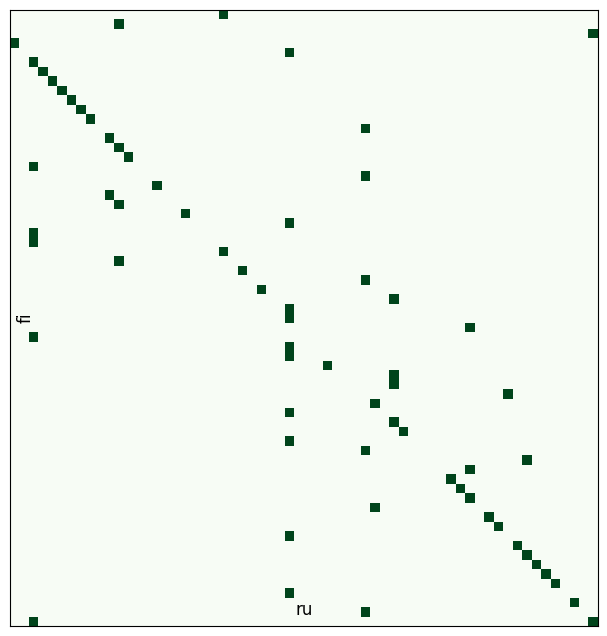

In [56]:
vis_helper.visualize_alignment_by_db(db_path, output_path="alignment_vis.png", lang_name_from=lang_from, lang_name_to=lang_to, batch_size=400, size=(800,800), plt_show=True)

## Опциональная часть. Нужна только, чтобы читать книги с параллельным переводом

In [57]:
conflicts_to_solve, rest = resolver.get_all_conflicts(db_path, min_chain_length=2, max_conflicts_len=6, batch_id=-1)

resolver.get_statistics(conflicts_to_solve)
resolver.get_statistics(rest)

conflicts to solve: 5
total conflicts: 7
('3:3', 4)
('6:6', 1)
('5:-1', 1)
('24:30', 1)


defaultdict(int, {'5:-1': 1, '24:30': 1})

In [49]:
resolver.show_conflict(db_path, conflicts_to_solve[4])

56 A bošši sanow: "Tüändiät d’o minuw d’ogirandah!"
57 Tüättih, ga cuarin poigu d’äl’l’es l’ähti.
58 Häi ku menöw vezirandah dai sanow: "Oi, sestrica Ol’onuška!


56 А баран и говорит: «Отпустите меня на берег реки!»
57 Отпустили, а царевич следом за ним и пошёл.
58 Баран как дошёл до берега реки и говорит: «Ой, сестрица Алёнушка!
-----------------------------------------------


({56: 'A bošši sanow: "Tüändiät d’o minuw d’ogirandah!"',
  57: 'Tüättih, ga cuarin poigu d’äl’l’es l’ähti.',
  58: 'Häi ku menöw vezirandah dai sanow: "Oi, sestrica Ol’onuška!'},
 {56: 'А баран и говорит: «Отпустите меня на берег реки!»',
  57: 'Отпустили, а царевич следом за ним и пошёл.',
  58: 'Баран как дошёл до берега реки и говорит: «Ой, сестрица Алёнушка!'})

conflicts to solve: 5
total conflicts: 7


100%|██████████| 5/5 [00:00<00:00,  6.66it/s]


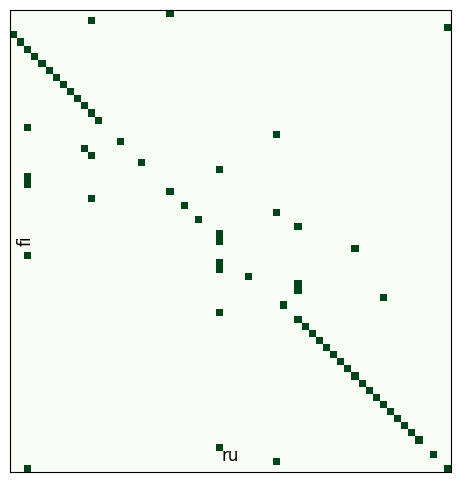

conflicts to solve: 0
total conflicts: 1


0it [00:00, ?it/s]


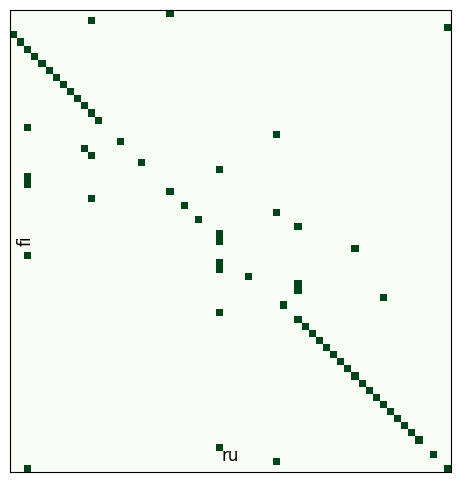

conflicts to solve: 0
total conflicts: 1


0it [00:00, ?it/s]


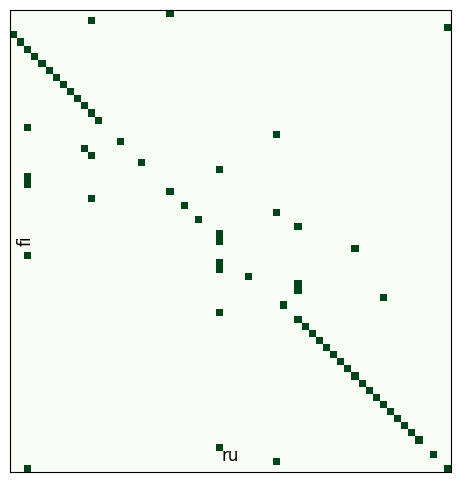

In [32]:
steps = 3
batch_id = -1 #выровнять все доступные батчи

for i in range(steps):
    conflicts, rest = resolver.get_all_conflicts(db_path, min_chain_length=2+i, max_conflicts_len=6*(i+1), batch_id=batch_id)
    resolver.resolve_all_conflicts(db_path, conflicts, model_name, show_logs=False)
    vis_helper.visualize_alignment_by_db(db_path, output_path="img_test1.png", lang_name_from=lang_from, lang_name_to=lang_to, batch_size=400, size=(600,600), plt_show=True)

    if len(rest) == 0: break

In [58]:
paragraphs, par_ids, meta, sent_counter = reader.get_paragraphs(db_path)

In [ ]:
# НУЖНО ТОЛЬКО ЕСЛИ СОЗДАВАТЬ КНИГУ В HTML
# output_path = "result/karelian_parallel.html"
# paragraphs, par_ids, meta, sent_counter = reader.get_paragraphs(db_path)
# paragraphs_from, paragraphs_to = paragraphs['from'], paragraphs['to']
# reader.create_book(['from', 'to'], paragraphs, [0], meta, sent_counter, output_path, template="simple")

In [59]:
len(paragraphs['from'][0]), len(paragraphs['to'][0])

(66, 66)

In [52]:
paragraphs['from'][0][56], paragraphs['to'][0][56]

('Tüättih, ga cuarin poigu d’äl’l’es l’ähti.',
 'Отпустили, а царевич следом за ним и пошёл.')

In [42]:
paragraphs['to'][0][-12], paragraphs['from'][0][-12]

('Никогда она не ненавидела его, она любила, из одной миски кормила, говорит, а, теперь велит зарезать?».',
 'Ei ni kows [vihannuh], sanow, suvaičči da ühtes astias süätti, – sanow, a nügöi käsköw iškiä?".')

# Создаём тестовый набор из Сказок (первый тестовый набор)

In [38]:
test_kar = [
    """Vot Kindahan miehet lähtiettih, kerävyi heidy arteli. Lähtietäh Piiterih, Piiterih talvel. Ajetah. Päivy ajetah kai. Kyläh mennäh yökse ga, mennäh ga, pajistah sillal sallow:
- Riet pidäw, - sanow, - kiändyä Piiterih päi, ed ajais, - sanow, - kodih järilleh.
No hyvä. A mužikku bokas kuulow. Kuulow bokas ga. Hyö muata vai ruvettih, mužikku otti, riet kiänäldi kai kodih päi järilleh.
Lähtiettih huondeksel, hevod val'1'astettih. Lähtiettih Piiterih. Lähtiettih Piiterih ajamah. Ajetah, ajetah gauml
- Ka tuaz on, - sanow, - gu rowno meijän sildu! 
- Sildu sildah koskehhai, eihai, - sallow.
Toine sanow gauml
- T'uaz on, - sanow, - gu rowno meijän kodi, - sanow. A meijän kylä on tämä! - sanow.
- Kylä kyläh koskehhäi, äijyhäi, - sanow, - on kylyä mual.
- Ka tuaz on gu rowno minun akku, - sanow, - nygöi sobii pezöw rannas!
- Akku akkah eigo koske! 
Akku ku kuulowhäi:
- Oho, propuaššoid! - sanow, - kodihgo tuliitto, iäre ajoitto? 
Sid hyö kodih tuldih. Sid ei tietty enämbi, kunne pidäw mennä. Dorogu loppih. Enämbi vs'o!""",
"""Kaksi vellesty elettih yhtes, heile rodih poigulapsi. Brihaččuine kazvatettih, tuattah kuolou (se kupsu). Nu tuattah gu kuollou, hyö oldih raviet kupsat. Tuodih tavarua ulgomerel, käydih tavarah ulgomeren kautti. Vanhin velli oli kaikin ozavin torgudielolois i nygöi sanotah: ”O tammo sen nasledniekan”.
Hyö lähtettih nämil purjeil. Tulou heile vastah suari, sanotah:
- Voizimmo gu probeijkseh täh suareh, suozimma yön magaizimma.
I suareh puututtih hyö. Sie oli kallio. Kallion piäl työnettih laudu, mendih sinne i ruvettih keittämäh syvvä da juvva. Keitettih, syödih, juodih i ruvettih muata. A brihačcuine ei viere muate, a lähtöy kävelemäh. Löydäy vinogruadumarjua, syöy i veröy muate. Vot brihaččuine se gu uinou muate. Diad’at nostih, rodieu perilline tuuli i tahtotah lähtie ielleh, a brihaččustu ei ole. Näit, gu häi syö marjuo i uinoi. Hyö ičitäh, löytä ei, rodieu myödäine tuuli. Hyö duumaijah, häi lähti lavval, kudai oli kallivol, i lähtitäh ielleh. A brihaččuine jäi suarel muate. Brihaččuine gu nouzou, opat’ syöy vinogruadu marjan i opat’ uinou muate, a diädet lähtettih iäres. Erähän kerran nouzou, kävelöy, kaččou: on haudu dai on veräi, a veräis on rengas, a rengahas on kangi. Häi rubei nečidä kangestu lekahuttamah:
- Voizingo nečien veriän avata? 
Häi duumaičči avata veriädy, lekahutti, lekahutti sidä kanges dai sai sen veriän avata. Veriän puutui avata. Häi käččou haudah. Haudas ollah pordahat dai pordahis nojaputkuh voit nojata. Lähti häi, heityi, heityi alah, tuli sinne mual, tuli vastah lagi da senčoi. Kaččou on uksi, täs pidäy olla pertti. Kaččou, on kiägy. Kiägah on opat’ pandu kangi. Häi duumaičči silleh:”Gu voizin nečen uksen avata, kaččozin, midä sie pertis on”. Häi lekahutti sidä kiägie, uksi avavui. Tuli petrih. Pertis valgei ku pihal. Kaččou pertih, pertis on pandu syömine stolal. Sie on äijy piiraidu stolal i viinua četverti. Häi duumaičcou:”Nečis syön nygöi!” Ottau keskes piiruan i syöy. Häi söi sit i duumaičči:”Midä mina nygöi ielleh ruan?” I hai duumaiččou nengoman:”Pidäy menna peittoh päčin tuakse, kačcuo, kedä tah tulou”. Hai konzu hörkitti päčin tagan, tuli puolen päivan aigu – 12 čuassuu. Tulou gospodin-starikku, häi tulou sorzis, kuuzi puarua sorzua räigiey lattiele. Heitti lattiele, otti lihapuan päčis da rubei syömäh. Otti četvertin viinua i kaiken ryyppäi. Syvvä puutui, starikku se söi da vieri muate divanal. Brihaččuine hörkötti päčin tagan. Kuulou: starikku tulou kai perti lekkuu. Brihačcuine duumaičči nengauml”Ku kuadiet starikal ollah leviet, menen kuadieloih peittoh”. F starikku maguau ga perti lekkuu. Häi perzevyksis meni, n’ulahtih. Starikku magai, ylen äijäl pierduu d’uvgai. Nu vot, häi gu pieri äijäl, brihaččuine d’aviv sinne i sanou:
- Tuataine, nouze iäreh, poijan sait!
Starikku nouzi, sanou:
- Hospodi pomilui! Muga minä duumaičin, vačču minul non suuri, olengo minä kohtuine. Kohtuine olen olluh. Täh minun jumal poijan andoi.
Starikku rubei hyvin pidämäh sidä brihaččustu, ole nikedä ei, aino poigu! Joga päivie starikku yksikai kävyi sorzih, joga päivie tuou kuuzi puarua sorzua. Händy kazvattau suurekse brihačukse. Kaččou: ”On täyzi mies, voit oman pian syöttiä!” Andau brihačul 12 avaindu, iče lähtöy sorzih merele. Avaimet andau, nevvou:
- Yhtestostu laukas syö-juo, kahtestostu älä avua.
Yksitostu net kai avai i duumaiččou:”Mindäh häi kahtestostu ei kaskenyh avata?”
Häi gu duumaičči silleh, mikse nečen kielli, pidäy nece kaččuo, midä sie on. Avai uksen, kui terväh uksen avai, mugagi terväh siepäi lähti kaksitostu djouččendu iäre. Brihaččuine se duumaiččou, paha mieli rodieu:”Kieldi, ei käskennyh avata, yksikai avain!”
Laukan sen salbai, tyhjan laukan, jouččenet lähtettih iäreh. tulou pertih, istuu hörköttäy pahas mieles:”Mikse avain gu ei käsketty!”
Puolenpäivän aigua tuli ižandy, kuuzi puarua sorzua heitti lattiel (joga päivie nait toi kuuzi puarua!), jouččenet net ugodittih lendämäh sil starikal vastah. Häi toi net jouččenet järilleh, net kodih toi, lavkah pani järilleh. Brihačul kyzymäh:
- Mikse sinä avait? Parahite ugodittih lendiä vasta, parahite ehtin tavata, muuten oldas kai lennetty!
Brihaččuine vastuau:
- Tuaten’ka, peitties avain, prosti!
Starikku prostiu. häi toizin päivin lavkois kävelöy, a sih sydämeh ei mene (lavkois enne vot ikkunat oldih madalat, kai nävyttih, ei gu nygöi). Häi kävelöy, kaččou, midä niis nägyy. Menöy sen lavkan kolkah, kaččou, midä eglaizet eläjät ruatah. Kaččou: kaksitostu neidisty kižatah (jouččenet oldih muututtu neidiziksi). Yksi neidine viidumaičči da tuli hänenluo ikkunalluo pagizemah. Yksi ulgoipäi, toine – pihalpäi pagizemah. Pagizemah meni brihankel läbi ikkunas, vastakkai. Brihal sanou häi:
- Ota minuu mučoikse!
- Kuibo minä maltan ottua sinuu? – briha vastuau häneleh.
Neidine se gu tariččes mučoikse, a briha sanou:
- Kuibo minä maltan ottua, munuu tiäten’ka ei vie naita!
Neidine sanou brihal silleuml
- Tiaten’kale sinä olet armas, ei häi sinun sanua yli mene, naittau, pyrgei vai!
Neidine sanou, gu häi andau naijauml
- Minun otat mučoikse, minä sinul sanon primietat. Sinun sanua yli mene ei, tule meillyö naimah. Myö olemmo gu yksi, kaksitostu neidisty, kai yksih sobih šuoritettu, bašmakat kaikil jallas. Naimah gu tuletto,- häi sanou,- ga valliče gu pidäy naija. Minä primietät sanon, yhtenmoizet sovat on piäl, yhtenmoizet bašmakat, valliče sinä sid minuu! Sid sinä minuu primieti käzii myöte sinä minuu primieti, käzii myö! Nimetöi sormi lekkuu bokkua myö, lopus sanouml”Tämän otan minä!”
Toizen kerran primietan nevvoi neidineuml
- Toizen kerran sellittäy uuzih sobih, rouno gu uvvet neidizet. Vot toine primiettu: huruas jallas ukkovarvas lekkuu – se olen minä!
Kolmas primiettu nevvou opat’ neidineuml
- Tuou opat’ meidy uvvis sovis, seizattau da sanou: ”Valliče nygöi!” Minul oččah lendäy kuldaine karbäine i lad’juo ielleh:”Täman minä otan!”
Nu vot, paginat paistut neidizenkel i häi tulou. Hospodinanke hyö eletäh, a häi joga paivie meččäh kävyy. Tulou kodih i sanou:
- Tiät’enka, naita nygöi minuu!
Tiät’enka vastuau hänelleh:
- Mi poigu sinul naimizii pidäy, nuori olet!
Häi vie enembän pyrgevymäh rubieu yksikai. Häi gu pyrgihze i rubei naittamah. andoi vallan naimah hänelleh, Vei niin neidizienluo lavkah. Šuoritti neidizet kai yhteh luaduh, tuldih gu yksi. Käsköy:
- Valliče, sinä, poigaine mučoi, kudai sinule pädöy!
Heil ku pagin oli paistu, nimetöi sormi sil lekkuu bokkua myö. Häi kaččou, kudamal sormi lekkuu bokal myödäh i sanou:
- Tämän minä otan!
Otti starikku neidizen, toizeh komnattah vei. Vei sie, neidizen sobih suoritti, on gi yksi kai. Toi toizen kerran;
- Valliče nygöi, poigaine, kudai sinule pidäy!
Häi kačoi: sil neidizel varvas lekkui bašmakas, häi kačoi jalgoi myöte, primieti, kudamal varvas lekui bašmakas dai sanoi:
- Tämän minä otan!
Opat’ ottau iäres neidizet, komnattah keriäy. Kolmanden kerran tuou neidizet yhtenmoizis sovis, sanou:
- Valliče nygöi mučoi!
Kolmanden kerran rubei valličemah gu pagin oli heile paistu, häi kaččou: kuldaine kärbäine istuihes oččah, dai sanou:
- Tämän minä otan!
Kolmanden kerran kačoi, valličči.
- Maltoit poigaine vallita, vothäi puutuit naizih. 
Mučoi davai eläjes ukkuo nevvomah. Hänelleh nevvou, käsköy ukolleh:
- Pyrgei sinä kodih, iäres työndämäh,- sanou,- ei ole rakas, ei rubie sinuu työndämäh. Sanouml”En ole sinun poigu!”
Nu vot tiäten’kah se kyzyy: 
- Kuibo,-sanou,- et ole minun poigu?
Nygöi rubieu häi iččeh elaigua sanomah tuatalleh.
- Vot,- sanou,-minä olin nengomas, nengomas linnas elämäs, minulleni tatin’ka kuoli,-sanou. Myö olimmo, kos tatin’ka kuoli da jäimmö diädelöinke elämah. Ulgo merih diädät lähtettih torguimah i minuu otettih tuatan stuači keral. Siit ajelimmo merdy myö dai tyynistih. Suari nägymäh rubei dai m dai myö menimmö suaren randah čuojuu keittamah, a siit tyynistih. Myö suaren randah piäzimmö. Suaren rannas on moine kallivon randu, siit galitas myö panimmo laudu dai sidä myö menimmö suarel. Söimmö-joimmo, diäd’at muate viertih, a mina lähtin suardu myö kävelemäh. Suarel lövvin ylen čomua vinogruadumarjuo, niidy söin i muate uinoin. minul muate uinota puutui dai hätki puutui muate. Diäd’at havačuittih, minuu löyty ei dai jätettih suarel. Suarel jäin dai hyö lähtettih ajamah. Suares magain, nouzin, opadi vinogruadumarjuo söin dai uinoin. Söin marjua aijän, jo himo lähti, enämbi en syö, muite kävelen suardu myö. Kavelin, kavelin suarel dai tuli haudu vastah, kačon: ”Mi neče havdoi on?” Havvan piäl on kriišku, veräi. Veriäs on rengas dai rengahas on kangi. Sidä minä davai lekuttamah, engo vois avatauml”Midä sie nägyy?” Puutui avata veräi, kačon: havvas on pitkät pordahat dai čurah-toizeh käzipuvu. Puutuin, alah heityin, tuli senčoi vastah dai sie on pertin uksi mendävy. Uksen kiägy, kiägäs kangi opadi. Minä sidä lekutiin dai avain uksen. Pertih menin: ni kedä pertis ei ole. Syömine oli stolal piiraidu oli sih lad’attu, kaikkie, viinua oli četvertine stolal dai četvertine stokan. Minä rubein syömäh, välis piiraidu söin, a viinua en koskenuh. Duumaičin, gu voizuin peittoh piästä:kedä tahto tulou täh. Minä menin peittoh päčin keskeh, kačoin, kedä täh tulou. Minä kačoin, sie hörkistin, sinä, tiatin’ka, tulit pertih, kuuzi puorua sorzua lykkäit lattiel, rubeit syömäh. Viinat kai valot četvertizeh r’umkah i kai kerras joit. Minä peitos sie päčin keskes kačoin midä sinä ruat. Syömäs lähtiit, divanal muate rubeit. Muate vieriit, uinoit äijäl divanal, kai perti lekkuu. Minä viidumaičin: muate uinoit aijäl, nu kui minä sinil jiävimmös. minä smietin muga jiävikseh. Sinul on kodiet suuret, vällät. Minä kuadien perzevyksih menin. Sinä ylen aijäl magait da pierduu muga tuikat dai minä paginan d’iävin, gu tiätin’ka sinä magait dai minuu sait. Nygöi sinul on sanottu, gu minä en ole sinun poigu. 
- Poigani, maltoin diävikseh, maltoin i vastah ottua. 
Häi käsköy kodih iäres, muudu ni midä. Tiäten’ka, se starikku, sanou hänelleh:
- Tahtot, ga mene, hyvä täs olis olla ga. Poigani,- sanou,- vägivaldua minä sinulles en lai. Tahtot, ga mene. Nygöi, poigani, komet suutkat pidäy vie vuottua, nygöi vie en voi työndie.
Kolmet suutkat hyö vuotettih. Tulou meres kolmen suutkan mendyy kaksitostu venehty tavarua sil starikal. Tiäten’ka se astuu randah i kyzyy škipparoil:
- Kudamis venehis on parahat tavarat?
Kolme venehty andau priduanoikse tyttärel da poijal parastu tavarua, kaikkii kallehemii, gu ni sis linnas ni kuultu ni nähty moizii tavaroi. Troikan andoi i kuldazen karietan, ni siit linnas ni kuultu moizii heboloi da kariettua. Hyö ruvetah lähtemäh iäres, proššaijahes dai häi työndäy tavaroin i venehien viz’at. Kirguu järilleh:
- Tule, poigani, mual kohtal järilleh.
Tuli mual, häin andoi poijalleh škatulin dai avaimet kädeh:
- Na, poigani, ota škatuli,-sanou,- tol’ko škatulin annoin, ga avaindu alä anna mučoile ni kos, avain iče pie. 
Proššaittahes toine kerdu dai lähtettih venehel škatulinkel. Kirgai vie toizen kerran:
- Tules vie, poigani, mual käymäh.
Tuli dai kolme luuhuttu andoi hänel kädeh, sanou;
- Pane luuhuot tiähtiel dai roih aigu, luuhuot kädeh kabrasta i iče näit midä roihes. 
Kolmanden kerran proššaittahes dai lähtietah matkah. Astutah, pyhiänpiän aigu, kodiperil astutah. Astuttih, puututtih rodiimoih storonah, sih linnah dai sih samaizih pristanih tullah. rahvas. Rahvas juostah: venehet tullah dai kogo linnu kerdyy sih kaččomah. Dai hänen iččeh diäd’at tullah sih pristanih, häin djavihes sih;
- Minä olen nengomua famiiliedu, viego diäd’at hengis ollah?
Parahitteh diäd’at ugotittihes pristanil dai sanottih:
- Olemmo myö täs diäd’at!
- Priimittö työ täs diäd’at minuu elämäh?
Diäd’at ihastuttih:
- Nu kui emmo priimi, gu puutui vie elävil silmil nähtä.
- Passibo, diäd’at, ku priimittö minuu yhteh, autakkua ottua kai tavarat venehes iäre, kai net on minun tavarat. 
Val’l’astetih hevot, izvoššiekat dai tavarat otettih kluaduloih. Hyö davai elämäh diädel’oinke sii yhtes, puutui omah kodih. Tuli mieli heile gul’aimah lähtie. Val’l’astettih hevot, lähtettih linnuo myö ajelemah, iččie ozuttamah. Hyö istuttihes sih kuldazih kariettoh. Ajetah linnuo myö, parahiteh suarin dvorčua myö pidäy ajua. Ajettih hyö suarin dvorčua myo, a Ivan Tsarevič ugodih heidy nägemäh. suarin poijal hyö kumardettihes, tervehys mennes laittih. Hyö ielleh ajettih. Ivan Tsarevič azetui heidy kaččomah: nengomua hebuo ni kariettua ei nähnyh ni mua tsarstvas. Kuni hyö ajettih i järilleh tuldih Ivan Tsarevič ainos vie siit seizou, hänel se meni vaččah: pideli se mučoi nähta lähembi. Ajelus se prodi, hyö kodih azetuttih elamäh. Suarin poijal lähiči himoitti nähtä i häin azui bualun, gu joga kupsu olis mučoinkel. Sanottih, gu joga kupsu mučoinkel tulis bualuh. Diäd’ot šuorittih, a hänen mučoi ei voi lähtie, vaččua rubieu kivistämäh. Häi yksinah lähti, a mučou ei voi lähtie. Kerruttih kai kupsat, pandih kupsat muččoloi rinnal. stolih puututtih kai. Ivan Tsarevič rubei eččimäh kenentäh luadi bualun dai stolat. Proidi, ei voinnuh löydie i uvvel kupsal sanou:
- Muil on mučoit, mindähbo sinul eule muččoi?
- Minul mučoi jäi vačan kivistykseh, ei voinnuh lähtie, sil dielol jäi kodih.
Jäi kodih ga tsarskoi lakei val’l’asti hevon i lähti ajamah. Hevon troikal azetti, meni pertih, ga mučoi gorniččuo myö proidii, kai bašmakku vonguu, eigo vaččua kivistä. Lakei kyzyy:
- Mindäh sinä et tulluh bualuh tsuarin poijal, kai häi oldih emändat dai ižännät kučuttih. 
Lakeil vastuau mučoil:
- Ei minul andanuh venčan aluzii sobii, a et häi lahte riihisovis tsarskoin stolah. En andanuh avaindu škatulis.
Tsarskoi lakei kyzyi:
- Etgo ni minunkel lähte?
Nu vot mučoi vastai hänel, sanou:
- En lähte kuni niidy sobii ei rodie minun piäl..
Tsarskoi lakei ajau järilleh, vei vieštii, sanou;
- Mučoi on terveh, proii gorniččuo myö vai bašmakku vonguu. Bualuh ei tulluh, ku ukkoh en andanuh parahii sobii škatulis, eihäi riihisovis tule tšarskoloih stolah. 
Ižändy otti, se uuzi kupsu, avaimen oijendi, sanou:
- Vie, anna šuoriu parahih sobih.
Tsarskoi lakei ajoi, avaimen kädeh mučoil andoi. Mučoi avaimet kädeh otti, škatulin avai, pani škatulin ikkunal, kovran otti, oijendi dai kovru lendi yhtestostu korolevstvas piäliči, kahtendentostu korolevstvah, tuatan korolevstvah. Sinne lendi, kodi jäi yksinäh i lakei lähti tyhjelleh ajamah, gu ei puuttunuh. Lakei tuli dai sanoi, gu dielo nenga on:
- Škatulin avai, pani ikkunal, oijendi, istuihes kovral da sanoi:”Lennä, kovru, yhtestostu korolevstvas piäliči, kahtendehtostu korolevstvah”,- sen i näin.
Uuzi kupsu jäi mučoittah, hänel tusku meni vaččah dai häi lähti kodih, kai stolat sinne jäi.. Tuli kodih ga kui lakei sanoi, muga gi on. Häi yksinah vuottau pahois mielis, ei voi ni kunne syndyö. Latiettu myö kävelöy, kuni bualu ei lopeh. Loppih se bualu, tullah diad’at kodih, häi diäd’oinke sovetuičeh. Diäd’oloil ilmoittau:
- Diäd’at,-sanou,- ongo teile naličnoidu kapitualua min vastah suitettu?
Diäd’at hänelleh sanottih. Häin sanou;
- Lähten muččoidu eččimah, en ni päesse hänen luo, ga hos kuollen dorogal, ga järilleh en tule, anduat den’gua dorogah. 
Mi on diäd’elöil kapitualua suitettu, hyö kai annetah hänelleh. den’gat annettih dai lähties sanottih nengauml
- Joga kohtu on den’gois tavotettu. Konzu pidänöy den’gua, työnämmö poštua myöte, den’gua gu loppeneh.
Häi lähti matkah, kus ajau mašinal, kus venehel, kus jalloi. Kai meni, meni matkoi, meni kahtendehtostu korolevstvah. Sih samah korolevstvah i linnah, kudamah mučoi meni. Puutui sih linnah i nägöy: rahvastu on ylen aijy kerdynyh yhteh kohtah, korolin koin oččah. Häin astuu linnua myö ielleh, linnan agjah, eigo kuulluh, eigo azetunnuh sih šumuh. Häi astui linnan agjah, menöy kaikkii pahimmah mökkih tariččemaheze yöksi. Buabušku yksinäh kois, leskiakku vahnu. Taričceheze yöksi, a leskiakku sanou;
- Yöksi se laskizin, ga ei ole syöttiä da juottua nimidä. Häi ähkäi käin kormanih, sanou:
- Mene osta syömistä da juomista, onhai linnas laukkoi!
Häi lugematta ahkäi den’gua buabuškal, buabuska osti kakkie syömisty-juomistu da vie den’gua jäi. Tuli buabuška kodih syömizen da juomizeke. Syödih da juodih dai häi rubei kyzymäh:
- Midä nenga teijän linnas šuumuu pietäh?
Buabušku vastuau:
- Meijän tytär oli kaksitostu vuottu kavoksis, se tuli nygöi kodih – sidä šuumuu nygöi pietäh. Koroli kuoli, pidäs uuzi koroli, tyttäreh kodavävy, sidä šuumuu pietäh. Ken vois peittyö - se rodizih korolikse, ken ei voi peittyö – piä pois poikki.
Vot buabuškal häi sanou:
- Minul on gadatel’noi kniigu i zirkalo, lasketannehgo minuu peittymäh. Ei voidanne löydie – minä korolikse, voidanneh löydie – piä poikki.
Mučoi puolenpaivässäh maguau, toizen čuasun zirkaloh kaččou da kolmanden čuasun šuorii i gadaiččou, mittuine se on objavlenii. Häi sen mučoin eččii, buabuškal sen dielon objavi i lähti peittymäh. Peittyö pidäy sil aigua konzu mučoi syöy da muate vieröy, kahtes čuasus. Vot dielo hänen piäl hänelleh i roih peittoh lähtendy. Häi puolipäivie roih, syöy dai muate kahtekse čuassuu, sil aigua hänel peittyö pidäy. Peittoh menemäh lähtöy, ottau kädeh kobristau luuhuon, kudaman starikku andoi. Luuhuot peittoh hänen vedäy meren randah. Meres tulou vahnin kala dai hänen ottau suuh- vaččah i vedäy keskimeren n’avale. Mučoi tiä magai, šuorii dai ottau zirkalon dai kahtekse čuasukse gadaiččemah lähtöy. Kaksi čuassuu gadaičči. Gadaičci muan – eule, gadaičči mečät –eule, gadaičči taivahan – eule, gadaičči meren i nägöy; keski mere n’avas kalan vačäs hai on. Dai sanou:
- Tule iäre!
Löydi kalan, kala toi hänen randah dai työndi iäre. toine päivy tulou. Myös puolen päivan aigua murginan syöy, kaksi čuassuu maguau, čuasun šuorieu da silmät pezöy, kahtekse čuasukse menöy gadaiččemah. Toizen kerran lahtöy peittoh, konzu suarin tyttö maguau. Ottäu luuhuon kädeh, kobristau dai nostau luuhuot händy pilvih. Mučoi nouzi muguamas, kolmanden čuasun šuorii da silmii pezi. Otti kniigan, seizatui zirkalon edeh i rubei gadaičcemah. Gadaiččemah rubieu, kaččou muan, mečän, vien – eule. Kačahtah pilvih, sanou:
- Täs olet, tule iäre.
Kolmaspäivy tulou. Mučoi puolen paivän aigua syöy, kaksi čuasuu maguau, čuasun šuorii da silmii pezöy i lähtöy kahtekse čuasukse kniigoinke, zirkalon tyveh gadaimah. Nygöi häi magavoaijal ottau kolmanden luuhuon, kädeh kobristau: ”Kunne luuhuot händy peittoh vedäy”. Rubei luuhuot händy vedämäh mučoin fatierah. Dežurnoi saldattu händy ei laske. Sil saldatal häi pokoroiččeh:
- Ota den’gua mitahto!
Saldattu sanou:
- Den’goittah minä rubien piäde menettämah da laskemah sinuu.
Häi pyrgiize. a saldattu duumaiččou: ”Sada rubljua andanet – äski viinua juon enne kuolenduo. A se mies vastah:
- Ota hot’ kaksi!
Den’gua nadoi, lugemattomah nosti, nosti:
- Viego pidäy,- kyzyy.
- Roiheze, velli,- sanou saldattu, tiä on jo kaksi sadua.
Vot sit saldatas piäzi, a toine dežurnoi vie pahembi. Häi pokoroičeh:”Ota, velli, mitahto, vai laske!”
Saldattu sanou:
- Piädy en rubie menettämäh den’gointäh. No andanet kaksi sadua, ga hot’ juon enne kuolendua.
- Ota velli hot’ kolme.
Häi op’at nosti dai nosti den’gua, sanou:
- Viego pidäy?
- Roiheze jo, mene, on täs kolme sadua, hot’ enne kuolendua juon. 
Kahtes dežurnois piäzi. Vot tulou kolmanden dežurnoin luo. Se ni d’amua panna ei laske. Hot pokoroičceh, pokoroiččeh:”Ota velli mitahto den’gua, vai laske!”
- En sinun den’gointah rubie piädy menettamäh. Andanet kolme sadua, ga mene, hot’ enne kuolendua juon.
- Ota velli hot’ nelli sadua vai laske.
Opat’ den’gua nosti, nosti lugemattah.
- Viego pidäy?
- Roih jo, mene, on täs jo nelli,- vastai hänel dežurnoi.
Kaikis dežurnolois piäzi, komes saldatas. Hai meni komnattah, kaččou: mučoi maguau – helmat ylahän. Otti kobristi luuhuon dai luuhuot händy vieldi zirkalon da kniigoloin välih. Zirkalo oli pečatnoidu levei da pitky, sen tuakse häi seizatui. Häi seizou hörköttäy. Mučoi noizi, šuorii, silmät pezi da meni gadaimah kahtekse čuassuu. Vie rahvas ollah kai pihal, čuasut net proijittih dai kirrutah:
- Uraa, meile koroli rodih, sait peityö.
Sit häi n’ulähtäy zirkalon tahas. Mučoi sanoi:
- Muga ozutti lähäl, a arvata en voinnuh.
Häi korolikse puutui, dielot kai priimi kädeh, häi sluužimah i rubei korolinnu. Kudamat saldatat dežurnoit händy piästettih pani vahnembih čiinuloih, a hyö duumaijah muga menöy.
Mučoinke elämäh hyö ruvettih, a mučoi häi yksikai armas ei rodinuh. Elettih hyö yhtes kodvaine aigua, käskiettih prusluugale kyly lämmittiä. Prisluugu kylyn lämmitti, käsköy:
- Mengiä nygöi kylyh, valmis on. 
Emändy jaksoiseze, toizet sovat ottau da jarähtäy ylen pahas tavas:
- Läkkä iäre nygöi kylyh.
Mužikku vastai hänele
- Mene, tulen jälles.
Mučoi vastai:
- Tule libo töllyö!
Mužikku se jäi kodih, mučoi lähti kylyh. Mužikku kodih jäi, emändy prisluuganke lähti kylyh. Pertis päčči oli lämmäs, sil aigua parahite mužikku jäi pertih. Häi otti, kovran päččih pani, zirkalon murendi palazikse pal’l’aze. Gadatel’noin kniigan päččih polti. Vot sit sarual meni, otti kolme tervulankua da lähti mučoidu kyl’vettämäh. Menöy kylyh. Prisluugu parahite mučoil selgiä hierou-viihkuttau. Välittyy iäre i ribieu muččoi piäliči olgupiälöi kyl’vettämah. Sit mučoi pageni, pagoh piäzi alači käzis da juoksi alasti kodih. Mužikkal kirguu:
- Et minuu hätkie syö-čiihuo, roih terväh agju ičelleh.
Häi sendah mugai sanoi, gu duumaičči: on sit kniigat-zirkalot endizelleh. Kodih mučoi meni, zirkalo lattiel paloinnu, kniigoga rabaih eule., kovrua rabaih eule. Kačoi häi – kai murennuh on, ole nimidä ei. Häi järilleh kylyh ukolluo. Ukolleh vieri jalgoi, sanoi:
- Kai hattar viet juon, kuundelemeh rubien mugalei. 
Vot sit kyly kylbettih dai ruvettih hyvin elämäh. Mučoi kuundelemah händy, a ukko – korolinnu. Työndi diäd’oileeh kirjazen:”Minä olen tiäl korolinnu, kodih minuu älgia vuotakkua. Elän hyvin dai piäzin endizen mučoinke elämäh.
Staarii-maalii, devitsa-vdovitsa – umnaja ukaza, perälinnoi prikaza/ Eto skazka ne skazka, skazka budet huondeksel hutun syödyy.""",
""" On ennen tijani. Luatiu pesän pajikolla. Muniu kolme jiäliččyä. Hautou ne
jiäličät. Tulou kolme poikaista. Lähtöy pojillah ruokua eččimäh. Mitä kärpäistä
suanou, niitä syöttäy poikasillah. Tulou kontie pajikon luokse, missä on tijasen
pojat. Pojat jo piästih lentoh ta lennettih koivun oksilla. Kontie siänty
pahapäiväsekse, söi pesän tai pajikon revitteli. Tulou tijani. Kontie mäni meččäh.
Kaččou, kun on pajikko revitelty, pesä syöty ta i pojat mihi lienöy suatu.
Pojat sanotah koivun oksiltauml
– Myö olemma, muamo, tiälä. Kun tuli mi lienöy hyvin suuri ta rupei meitä
syömäh, myö pakoh. Pesän söi tai pajikon revitteli.
Tijani sanou:
– Oliko miun suurus?
Pojat sanotah:
– Et ole ni silmän suurus sie, niin suuri oli.
Tijani pörhistäy sulkah, siipeh ta kysyy:
– Oliko näin suuri?
Pojat sanotah:
– Et ole ni korvan suurus, se oli niin suuri.
Tijani arvuau, jotta kontie oli. Kysyy pojiltah:
– Mihi päinpä läksi se suuri mänömäh?
Pojat sanotah:
– Tuonne mäni meččäh.
Tijani sanou pojillah:
– Työ olkua tässä, mie lähen suan hänen kiini ta vien suutuh.
Läksi tijani lentämäh tai sai kiini, tarttu hänellä korvah, sanou:
– Siekö miun pojat ajoit pesästä, pesän söit, ta pajikon revittelit?
Kontie sanou:
– Mie.
Tijani sanou:
– Mitä sie siinä ruavoit?
Kontie sanou:
– A mie olen sieltä syöjä, sieltä suaja, miun pitäy syyvvä, mitä mistä suan.
Tijani sanou:
– Lähe suutuh linnalla.
Tai viey tijani kontien suutupaikkah. Sanou sut’jallauml
– Tämä kontie miula pahua ruato, mitä suutit nyt?
Sutja sanou:
– Suutimma myö hänen hännättömäkse.
Kontie sanou:
– Elkyä työ miulta suutikkua koko häntyä, jättäkkyä puoli häntyä.
Kontiella puoli häntyä jätettih. Tijani läksi poikieh luo. Kontie mäni
meččäh ta itköy, kun häneltä puoli häntyä suutittih.
Tulou repo vastah kontiella, kysyy:
– Mitä itet, kontie?
Kontie sanou:
– Iten kun hännättömäkse suutittih, vain ei ne koko häntyä, kuin puoli häntyä.
Repo sanou:
– Lähe meilä, rupiemma yhessä elämäh.
Siitä männäh kontien keralla revon kotih. Repo on löytän matikkakesselin.
(Tuommosen kuin siun kesseli tuola nurkassa.) Repo ta kontie ruvettih
kuomaksikse. Kontie kysyy:
– Mistä sie, kuomasen, olet matikkua suanun?
Repo sanou:
– Ka mie olin onkella viime yönä.
– Mistä sie, kuomasen, onkitit ta millä?
– Mie mänin pappilan avantoh, ta pissin häntäni. Joka karvah tarttu
matikka.
Kontie sanou:
– Lähen ni mie, on miula vielä puoli häntyä.
Läksi kontie onkella. Se on jo pimie ilta.
Kontie mänöy, panou häntäh avantoh, ta iče avannon piällä istuutuu
rähähtäy.
On hyvin pakkani yö.
Kontielta alko häntyä näpissellä pakkani, kun alko kylmyä avantuo.
Kontie ajattelou:
– Nyt niitä puuttuu, kun alko näin näpissellä häntyä. Pitäy nostua nämä
matikat jiän piällä, ni siitä onkitan toista.
Kontielta koko takapuoli kylmi avantoh, ajattelou:
– Nyt tarttu niin äijän matikkua, jotta en suata nostua.
Ei piäse kontie avannosta, siinä istuu.
Huomeneksella pappilan piijat tullah vejellä. Lyyvväh korennolla kontieta.
Kontie kisalti häntäh, puoliki häntyä jäi sinne. Hiän mänöy revon luo, sanou:
– Niin äijäkö lienöy puuttun matikkua, vain lienöykö siitä häntä katen, kun
pappilan piijat korennolla lyötih.
Repo sanou:
– Kun et liikutellun, niin se kylmi. Mie luajin tulen tähä, niin lämpiet. Repo
kokoi tervasta ta luati tulen. Kontiella sanou:
– Istuuhu, kuoma, tähä tulen piällä lämpiemäh.
Kontie siihi palo ta repo iče pakoh. Muutki kontiet jäi hännättömikse, kun
siltä yheltä kontielta oli häntä suutittu.""",
"""Ukko ta akka oltih jo vanhat. Ruvettih hyö kiukualla muate. Pirtin piällä
tuli orava. Sielä lotajau, krapajau, ei anna heilä yörauhua. Akka sanou ukollauml
– Mäne pane lautani pirtin piällä, eikö se orava puutu.
Ukko nousi pirtin piällä ta pani sinne lautasen. Tuli takasin pirttih, rupei
muate. Jo orava tuas ni tuli pirtin piällä. Tai puuttu lautaseh. Sielä lotajau
lautasessa. Akka sanou ukollauml
– Mäne ota, jo orava puuttu lautaseh.
Ukko nousou pirtin piällä, rupei ottamah oravua lautasesta. Tai toreuvuttih
ukko ta orava. Orava kun löi korvalla ukkuo, hiän i kirpoi pirtin piältä. Ukko
kuoli. Orava otti salmosta ahkivon ta pani ukon ahkivoh. Läksi vetämäh ukkuo
ahkivossa. Tuli jänis vastah, kysyy oravaltauml
– Mitä vejät, orava?
Orava sanou:
– Vejän ukkuo, hyvyä miestä.
Pani pihet pirtin piällä,
Lautasen lapukin piällä,
Iče puuttu pihtihih,
Lankei lautasih –
Miula, mečän juoksijalla,
Rahakarvan kantajalla,
Huutehessa huksajalla,
Hämärässä häkläjällä.
Jänus sanou:
– Ota milma vetämäh.
Orava sanou:
– Haukkua palani ukkuo tai vejämmä kahen.
Lähettih vetämäh. Vejetäh kotvani. Tulou hukka vastah, kysyy:
– Mitä vejät, jänis?
– En mie vejä, orava vetäy, – sanou jänis.
Hukka kysyy:
– Mitä vejät, orava?
– Vejän ukkuo, hyvyä miestä.
Pani pihet pirtin piällä,
Lautasen lapukin piällä,
Miula, mečän juoksijalla,
Rahakarvan kantajalla,
Iče puuttu pihtihih,
Lankei lautasih.
Sanou orava hukallauml
– Haukkua palani ukkuo ta lyöttäyvy vetämäh.
Vejetäh vähän aikua. Tulou kontie vastah.
– Mitä vejät, hukka?
– En mie vejä, jänis vetäy.
– Mitä vejät, jänis?
– En mie vejä, orava vetäy (orava kun on isäntä).
Orava sanou kontiellauml
– Syö ukkuo palani ta lyöttäyvy vetämäh.
Kontie i söi ukon niin, jotta jäi vain muruni piätä ahkivoh.
Tulou repo vastah, kysyy:
– Mitä vejät, kontie?
– En mie vejä, hukka vetäy.
Hukka sanou:
–En mie vejä, orava vetäy.
– Mitä vejät, orava?
Orava sanou:
– Vejän ukkuo, hyvyä miestä.
Pani pihet pirtin piällä,
Lautasen lapukin piällä,
Miula, mečän juoksijalla,
Rahakarvan kantajalla,
Huutehessa huksajalla,
Hämärässä häkläjällä.
Iče puuttu pihtihih,
Lankei lautasih.
Orava sanou revollauml
– Syö tuo loppuni ukko.
Repo söi sen viimesen piäpalasen. Vejetäh tyhjyä ahkivuo koko joukolla.
Kontie sanou:
– Nälkä tuli. Ku pienin, ku pienin, se syyvväh!
Orava syötih. Vejettih tuas vähäni aikua, kontie tuas sanou:
– Nälkä tuli. Ku pienin, ku pienin, se i syyvväh!
Jänis syötih. Repo sanou hukallauml
– Läkkä pakoh. Syöy miät kontie.
Hukka ta repo meččäh pakoh juoksomah. Kontie vetäy yksinäh tyhjyä ahkivuo.
Sanou kontieuml
– Nälkä tuli. Ku pienin, ku pienin, se i syyvväh!
Käcahtau jälelläh: ei ni ketänä matalla, kun tyhjä ahkivo. Kontie siänty
pahanpäiväsekse. Löi ahkivon puuhu säpälehikse, iče läksi meččäh. Siihe i
loppu starina"""
]
test_rus = [
    """Вот поехали киндасовские мужики, собралась их целая артель. Едут в Питер, в Питер зимой. Едут. Целый день едут. В деревню заезжают на ночь, заезжают, да и разговаривают на мосту, говорит [один]:
- Возы надо, - говорит, - повернуть оглоблями в сторону Питера, не поехать бы, - говорит, - обратно домой.
Ну хорошо. А мужик со стороны слышит. Слышит со стороны. Они только легли спать, мужик взял сани все повернул обратно, в сторону дома.
Собрались утром, лошадей запрягли. Поехали в Питер. Отправились в Питер. Едут, едут, так:
- Да тут, - говорит, - будто наш мост.
Мост на мост приходится ведь, не без этого, - говорит.
Второй и говорит:
- Там, - говорит, - как будто наш дом, - говорит. - А это наша деревня, - говорит.
- Деревня с деревней сходится, ведь много же, - говорит, - деревень на свете.
- Да вон будто бы как моя жена, - говорит, - сейчас белье стирает на берегу.
- Жена с женой разве не бывают схожи?
Жена-то как услышит:
- Ох, вы, окаянные, - говорит, - домой и возвращаетесь, обратно приехали!
Тут они домой приехали. Потом не знали больше, куда надо ехать. Дорога кончилась. Больше - всё.""",
"""Два брата жили вместе, у них родился сын. Вырастили мальчика, отец умер (тот купец). Отец как умер, а они были богатые купцы. Привозили товар из-за моря, за товаром ездили за море. Старший брат был самым удачливым в торговых делах, они и говорят: «Возьмем этого наследника».
Отправились они на этих парусах, увидели впереди остров, говорят:
- Сможем ли мы пробиться к этому остову. смогли бы там переночевать.
Попали они на остров. Там была скала. На вершину скалы протянули доску, пробрались на остров, стали есть-пить готовить. Приготовили еду, поели-попили, стали спать укладываться. А мальчик не ложиться спать, отправился гулять. Нашел он виноградные ягоды, поел их и спать лег. Проснулись дяди, попутный ветер, хотели дальше в путь отправиться, а мальчика нет. Видишь, он ягод поел и уснул. Они искали, найти не смогли. Подул уже встречный ветер. Подумали дядюшки, что взобрался он на доску, что к скале приставлена, и поехали дальше, а мальчик остался на острове спать. мальчик снова проснулся, еще раз виноградных ягод поел и опять уснул, а дядюшки уехали. В очередной раз встал, ходит-смотрит: там яма, в ней дверь, на двери - ручка, в ручке – палка.
- Смогу ли я эту дверь открыть?
Думал он дверь открыть, трогал он трогал эту палку и открыл эту дверь. смог он дверь открыть. смотрит он в эту яму. В яме лестница, по лестнице можно спуститься. Он спустился вниз на землю, увидел там потолок и коридор. Смотрит: там дверь, за ней может быть комната. Видит – ручка. В ручке опять палка продета. Он так думает: «если бы я смог эту дверь открыть, увидел бы, что там в комнате». Дверь открылась. Вошел он в комнату. В комнате светло, как на улице. Смотрит – а там стол накрыт. Много пирогов на столе и вина четвертинка. Он думает: «Теперь я тут поем!» Берет с серединки пирог, ест его. Съел он и думает: «Что я дальше делать буду?» он так подумал: «надо за печкой спрятаться, посмотреть, кто сюда придет». Он когда спал-посапывал за печкой, время пришло к полудню, к 12 часам. Пришел старик-господин, он пришел уткой (с утками), шесть пар утор на пол кинул. Кинул на пол, взял с печи чугунок с мясом и стал есть. Взял вина четверть и все выпил. Удалось поесть, поел старик и лег спать на диван. Мальчик посапывал за печкой. Слышит: идёт старик – комната шатается. Мальчик так думает: «Кальсоны у старика широкие, спрячусь я в кальсонах». А старик спит – комната шатается. Он сзади в кальсоны пробрался- проскользнул. Старик спал, очень сильно пукал. Он как сильно пукнул, мальчик появился и говорит:
- Отец, просыпайся, ты сына родил!
Старик проснулся, говорит:
- Господи помилуй! Так я и думал, живот у меня большой, неужели я беременный. Беременный оказался. Здесь мне Бог сына послал.
Старик стал за ним, за тем мальчиком, хорошо ухаживать: не было у него никого, единственный сын! В каждый день он все равно ходил за утками. Вырастил он мальчика. Смотрит: «Уже взрослый мужчина, можешь свою голову прокормить!» Дает мальчику 12 ключей, сам на море за утками отправился. Ключи дал. говорит:
- В одиннадцати лавках ешь-пей, а двенадцатый не открывай!
Одиннадцать все мальчик открыл и думает: «Почему же он двенадцатый не позволил открыть?»
Он так думает, почему этот запретил открывать, надо его посмотреть, что там. Открыл дверь. Как он только дверь открыл, так сразу оттуда 12 лебедей вылетело. Думает мальчик: «Запретил ведь, не разрешал открывать, все равно открыл!»
Закрыл ту лавку, пустую лавку, лебеди улетели. Зашел в дом, сидит сердитый, думает: «зачем открыл, ведь не разрешили!»
В полдень пришел хозяин, шесть пар уток на пол бросил (в каждый день приносил по шесть пар уток), а лебеди те как раз навстречу старику прилетели. принес он тех лебедей обратно, домой принес, в лавке запер опять. Стал у мальчика спрашивать:
- Зачем ты открыл? Хорошо мне навстречу попались, успел поймать, не то уже улетели бы!
Отвечает мальчик:
- Тятенька, случайно открыл, прости!
Старик простил. На другой день он по лапкам ходит, а туда (в 12) не заходит (в лавках раньше окна были низкие, все было видно, не то, что теперь). Встал на углу 12 лавки, смотрит, чем его жильцы там занимаются. Смотрит: 12 девушек играют (лебеди в девушек превратились). Одна девушка подошла к окну, стала с парнем разговаривать. Один снаружи, другой – изнутри, так разговаривают. девушка с парнем разговаривают там через окно. Парню она говорит:
- Возьми меня в жены!
- Как же я тебя возьму?- парень ей отвечает.
Девушка замуж просится, парень ей отвечает:
- Как же я могу взять, тятенька меня еще не женит!
Девушка так говорит парню:
- Тятенька тебя любит, поперек твоих слов не пойдет, попросись жениться!
Девушка говорит, что тятенька позволит ему жениться:
- Меня в жены возьмешь, я скажу тебе приметы. Поперек твоих слов не пойдет, приходи к нам жениться. Мы все двенадцать похожи друг на друга, все в одинаковую одежду одеты, у всех башмаки на ногах. Как жениться придешь,- она говорит,- выбирай, если хочешь жениться. Я приметы скажу, одинаковая у нас одежда. одинаковые башмаки, выбери ты меня! Ты меня узнай по рукам, по рукам! Безымянный палец у меня шевелиться будет. В конце скажи: «Эту в жены возьму!»
Поведала девушка на другой раз примету:
- Во второй раз оденет в новую одежду, будто бы другие девушки перед тобой появятся. Вот вторая примета: на правой ноге большой палец шевелиться – это буду я!
Третью примету опять рассказала девушка:
- Приведет опять нас в новой одежде, поставит в ряд и скажет: «Выбирай теперь!» Мне лоб сядет золотая муха, ты и скажи: «Эту я возьму в жены!»
Поговорил он с девушкой и приходит хозяин. С господином они живут, он в каждый день в лес ходит. Вернулся оно домой, сын ему говорит:
- Тятенька, жениться я хочу!
Тятенька ему отвечает:
- Что тебе за женитьба, молодой еще!
Еще больше стал он просить все равно. он как стал проситься жениться, разрешил ему хозяин. Отвел к девушкам в лавку. Девушек одел в одинаковые одежды, пришли все как на одно лицо. Говорит:
- Выбери теперь ты, сыночек, себе жену, какая тебе по нраву!
Они как заранее условились: безымянный палец шевелиться должен. Парень смотрит: безымянный палец по боку шевелиться и говорит:
- Эту я возьму!
Собрал старик девушек, в другую комнату увел. Там он их в одежды одел, все как на одно лицо. привел во второй раз:
- Выбери теперь, сынок, какая девушка тебе по нраву!
Он смотрит: у девушки палец в башмаке шевелится. Он смотрит по ногам, у которой палец в башмаке шевелиться, и говорит:
- Эту я возьму!
Снова старик девушек увел, собрал в другой комнате. В третий раз привел девушек в одинаковой одежде, говорит:
- Выбирай теперь жену!»
В третий раз стал выбирать, как было условлено, он смотрит, кому золотая муха на лоб сядет. он говорит:
- Эту я возьму!
На третий раз смотрел и выбрал.
Смог ты, сыночек, выбрать, можешь жениться.
Жена стала мужа учить. Ему говорит, указывает:
- Попросись ты домой,- говорит. Не захочет он тебя отпускать. Скажи ему, что ты не его сын.
Вот тятенька и спрашивает:
- Как же ты не мой сын?
- Так, говорит,- я жил в том-то, в том-то городе. У меня умер тятенька, Остался я жить с дядюшками. За моря поехали дяденьки торговать и меня взяли за место отца. Плыли мы по морю, море стихло. Увидели мы остров, стали мы к берегу приплывать, чтобы чаю там попить. Приплыли мы к берегу острова. Берег там был скалистый, мы с галиоты скинули доску и по ней пробрались на остров. Поели-попили, дяденьки спать легли, а я пошел по острову гулять. Нашел я на острове очень красивые виноградные ягодки, их я поел и уснул. Уснул я и проспал долго. Дяденьки проснулись, не нашли меня, так на острове и оставили. На острове я остался, а они уехали. Спал я на острове, проснулся. Опять виноградных ягод поел и уснул. Много я ягод поел, уже не хотелось больше, перестал есть, просто по острову гулял. Гулял-гулял, увидел яму, думаю, что это за яма? Яма накрыта крышкой, на ней дверь. На двери кольцо, на кольце – ручка. Ее я стал шевелить, может смогу открыть. «Что там видно?»- думаю. Удалось дверь открыть, смотрю: в яме длинная лестница и по обе стороны ручки. Туда я попал, в яму спустился, увидел коридор и дверь, которая в комнату ведет. На дверях запор, в запоре ручка. Я ее пошевелил – и открыл дверь. Вошел в комнату – там никого. На столе еда, пирогов всяких наложено, вина четвертинка и стакан в четвертинку. Стал я еду пробовать, пироги в промежутке, а вина не трогал. Думал, что надо бы мне спрятаться: кто-нибудь наверняка сюда придут. спрятался я за печку, смотрю. кто в комнате появиться. сижу я там тихонечко, а ты, тятенька, в комнату пришел, шесть пар уток на пол бросил и стал есть. вино все в четвертинную рюмку вылил и все выпил. Я там тихонько из-за печки смотрел, что ты делаешь. Поел ты, стал на диване спать. Спать стал, крепко на диване уснул, даже дом зашевелился. Я придумал: коль ты крепко уснул, я там и появлюсь. Так я решил появиться. У тебя кальсоны широкие, свободные. Я в кальсоны сзади забрался. Ты очень крепко спал, попукивал. Я и стал говорить, что, тятенька, ты спал и меня на свет родил. Теперь я тебе рассказал, что я не твой сын.
- Сыночек, сумел появиться, сумей и выслушать.
Парень домой просится, больше ничего ему не надо. Тятенька, этот старик, ему говорит:
- Хочешь – ступай, хотя тебе и здесь было бы хорошо. Сыночек,- говорит он,- удерживать тебя не стану. Хочешь – ступай. Только теперь еще трое суток надо подождать, сразу не могу отпустить.
Трое суток они подождали. Пришли с моря через трое суток 12 лодок, привезли товар старику. Тятенька идет на берег моря и у шкиперов спрашивает:
- В какой лодке лучший товар?
Три лодки собрал он приданого дочери и сыну лучшего товару, самого дорогого товару, ни в каком городе не видели и не слышали о таком товаре. Дал он им тройку и золотую карету, даже в том городе не слышали о таких тройках и каретах. Стали они в дорогу собираться, отпускает он их. Потом снова кричит:
- Вернись, сынок, снова на землю!
Вернулся парень на землю, дал старик сыну шкатулку и ключи:
- Возьми, сынок, шкатулку,- говорит,- только как дал я тебе шкатулку, не давай ее жене никогда, ключ при себе держи.
Попрощались во второй раз, поехали в лодке со шкатулкой. Во второй раз кричит:
- Вернись, сынок, еще на землю!
Вернулся парень, старик ему три косточки дал и говорит:
- Сохрани эти косточки, придет время, в руку их возьми, сам увидишь. что получится.
В третий раз попрощались и отправились в дорогу. Едут, дело было в воскресный день, домой едут. Ехали и попали на родную сторону, в тот самый город. на ту самую пристань. Народ бежит: лодки к берегу подошли, народ собрался их смотреть. И его родные дядюшки на пристань пришли. Парень там говорит:
- Я такой то фамилии, еще ли живы мои дядюшки?
В это самое время дядюшки были на пристани, они говорят:
- Тут мы, твои дядюшки!
- Примите ли вы меня к себе жить?
Дядюшки обрадовались:
- Как же не примем, коль посчастливилось еще на этом свете увидеть.
- Спасибо, дядюшки, за то, что приняли меня к себе, помогите товар с лодок разгрузить, это все мой товар.
Запрягли лошадей, извозчики весь товар уложили в ящики. Стали они с дядюшками вместе жить, попал он в свой дом. Захотелось молодым погулять пойти. Запрягли лошадей, поехали по городу себя показать. Они очень обрадовались этой золотой карете. Ехали они по городу, как раз мимо царского дворца надо ехать. Ехали они мимо царского дворца, Иван Царевич их увидел. Поклонились они царскому сыну, поздоровались с ним и дальше поехали. Иван Царевич остановился на них посмотреть: такой кареты не видела даже земля в этом царстве. Пока они ехали и снова возвращались по той же дороге, Иван Царевич на одном месте стоял. Одна мысль в нутро засела: хотелось очень на жену вблизи посмотреть. Закончилась эта прогулка, пошли они в дом. А царскому сыну вблизи хотелось на жену посмотреть, и он решил собрать бал, чтобы все купцы были на нем с женами. Было объявлено, чтобы все купцы пришли с женами на бал. Дядюшки оделись, а жена у парня не может пойти: живот стал болеть. Он все равно пошел. Собрались все купцы, встали они с женами рядом. За столы всех усадили. А Иван Царевич стал искать ту, из-за которой он бал собрал и угощения на стол. Прошелся по дворцу, не мог найти. Спрашивает у нового купца:
- Все с женами пришли, где же твоя жена?
- У моей жены живот заболел, не смогла пойти на бал, по этой причине дома осталась.
Дома осталась, но царский лакей коня запряг и поехал. Тройку запряг, в дом вошел, а жена по горнице вышагивает, даже башмаки звенят: не болит живот. Лакей спрашивает:
-Почему ты на бал к царскому сыну не пришла, всех хозяек с хозяевами позвали.
Отвечает жена лакею:
- Не дал мне муж подвенечного наряда, не пойдешь ведь на бал в лохмотьях. Не дал мне ключа от шкатулки.
Царский лакей спрашивает:
- А со мной не поедешь?
Жена ему отвечает:
- Не поеду, пока той одежды на мне не будет.
Поехал царский лакей обратно, привез весть, говорит:
- Жена та здорова, по горнице ходит – только башмаки скрипят. А на бал не пришла потому, что не дал ей муж лучших нарядов, не пойдешь ведь в лохмотьях за царский стол.
Взял хозяин, тот новый купец, подал ключ и говорит:
- Отвези, скажи, пусть одевается в лучшие одежды.
Царский лакей поехал, ключ в руки жене отдал. Жена ключи в руки взяла, шкатулку открыла, подняла ее на подоконник, взяла оттуда со шкатулки ковер, его расправила. Полетел ковер через одиннадцать королевств в двенадцатое королевство, в королевство отца. Туда улетело. Дом пустой остался и лакей с пустыми руками обратно поехал, не смог он жену привезти. приехал лакей, говорит. что так и так дело было:
- Шкатулку открыла, на подоконник положила, села на ковер: «Лети, ковер, через одиннадцать королевств в двенадцатое королевство,- это я видел.
Новый купец без жены остался, тоска его заела, и он пошел домой, угощения там остались. Пришел домой: все так, как лакей сказал. Он ждет один в плохом настроении, не знает, куда себя деть. Ходит по комнате, пока бал не закончился. А бал как закончился, пришли дядюшки домой, он с ними советуется, дядюшкам объявляет:
- Дядюшки, - говорит,- сколько наличного капитала у вас накоплено?
Ответили ему дядюшки. Он опять говорит:
- Пойду я жену свою искать, хоть и не доберусь до нее, хоть и умру где по дороге, но обратно не вернусь. Дайте мне на дорогу денег.
Сколько у дядюшек капитала было собрано, все ему отдали, деньги отдали, а перед дорогой сказали так:
- В любом месте мы от денег зависим. Когда тебе деньги понадобятся, отправим тебе по почте, если деньги закончатся.
Отправился он в путь, где на машине едет, где на лодке, где пешком. Все прошел, прошел дороги, оказался в двенадцатом королевстве. Пришел в то самое королевство и город. куда жена ушла. Очутился в том городе и видит: народу очень много собралось в одном месте, под передней стеной короля. Он пошел по городу дальше, в конец города, не слышал и не остановился на этот шум. Пришел он на окраину, в самую дряхлую избушку просится переночевать. Бабушка там одна дома. старая вдова. просится он на ночлег, а вдова ему говорит:
- Пустила бы на ночь, да нечем накормить-напоить.
Он руку в карман запустил, говорит:
- Иди купи поесть-попить. есть же в городе лавки!
Он не считая денег сунул бабушке, взяла их бабушка, купила всего поесть-попить, да еще денег осталось! Пришла бабушка домой с едой-питьем. Поели-попили и он стал спрашивать:
- Чего это в вашем городе такой шум?
Отвечает бабушка:
- Наша дочка двенадцать лет пропадала. теперь домой вернулась – поэтому народ шумит. Король умер, надо бы нового короля, примака для дочери, поэтому шум в городе. Кто сможет спрятаться, тот будет королем, а кто не сможет – тому голова с плеч.
Он отвечает бабушке:
- У меня есть гадательная книга и зеркало, пустят ли меня прятаться. Не смогут если найти – я – король, а смогут – голова с плеч.
Жена до полудня спит, второй час в зеркало смотрит, третий – одевается и гадает, такое у них объявление. Он эту жену нашел, бабушке это рассказал и пошел прятаться. Спрятаться надо в то время, пока жена ест и спать собирается, за два часа. Уже время прятаться идти. Уже полдень, жена кушает и спать идет на два часа. В это время ему спрятаться надо. Как прятаться пошел, в руке он кость зажал, которую ему старик дал. кость его прятаться ведет на берег моря. из моря поднимается самая главная рыба, его проглатывает и несет на середину моря. А жена тут спит, одевается, берет зеркало и на два часа гадать идет. Два часа гадает. На земле ищет – нет его, в лесу – нет его, на небе – нет его. Ищет на море и видит: посреди моря он в утробе рыбы. Она говорит:
- Возвращайся!
Нашла рыбу, рыба принесла его к берегу и выпустила. Второй день наступил. Опять в полдень обед наступил, два часа потом спит, час одевается и глаза моет, на два часа идет гадать. Во второй раз отправился прятаться, пока царская дочь спит. Взял косточку в руку, зажал ее и подняла косточка его в облака. проснулась жена, третий час одевается и глаза моет. Взяла книгу, встала у зеркала и стала гадать. Стала она гадать, смотрит землю, леса, воду – не его нигде. Смотрит в облака, говорит:
- Ты там, возвращайся!
Третий день наступает. В полдень жена обедает, два часа спит, час одевается и глаза моет. На два часа потом уходит с книгами к зеркалу гадать. Теперь во время ее сна он берет в руки третью косточку, в руке зажимает: «Куда косточка его спрячет?» Повела его кость в квартиру жены. Дежурный солдат его не пускает. Он просит солдата:
- Денег возьми, сколько пожелаешь!
Солдат говорит:
- Из-за денег я не буду свою голову терять и тебя пускать.
Он просится, а солдат думает: «Если сто рублей дашь – смогу хоть вина попить перед смертью». А мужчина ему отвечает:
- Возьми хоть две сотни!
Дал он денег, бесчисленное количество их достает, достает:
- Еще ли надо?
- Хватит уже,- говорит солдат,- тут уже две сотни.
Прошел через солдата. а второй дежурный еще хуже. Он просит: «Возьми сколько хочешь – только пусти!» 
Солдат отвечает:
- Голову свою из-за денег терять не буду. Но если две сотни дашь – хоть вина попью перед смертью.
- Возьми хоть три!
Он опять деньги все достает, достает, говорит:
- Еще ли надо?
- Хватит уже, иди. Здесь три сотни, хоть перед смертью напьюсь.
Через двух дежурных прошел. Вот идет он к третьему дежурному. Он не пускает. мужчина просится, просится: «Сколько хочешь денег возьми, только пусти!»
- Из-за твоих денег не буду я свою голову терять. Если три сотни дашь, то иди, я хоть перед смертью напьюсь!
- Бери хоть четыре сотни, только пусти!
Опять денег все достает, достает бесчисленно.
- Еще ли надо?
- Хватит уже, иди, есть тут уже четыре сотни,- ответил дежурный. 
Через всех дежурных прошел, через трех солдат. Он пошел в комнату, смотрит: спит жена. подол задран. Взял, косточку зажал, и косточка его провела между зеркалом и книгой.. Зеркало было широкое и длинное, за ним он встал. Стоит он. Жена проснулась, глаза помыла и пошла гадать на два часа. А люди на улице стоят, время вышло, они кричат:
- Ура, у нас король появился, смог он спрятаться.
Он появился из-за зеркала. Говорит жена:
- Показывало близко, не смогла угадать, где ты спрятался.
Он стал королем, дела взял с вои руки, стал служить королем. Всем дежурным солдатам, которые его пропустили, дал он чин повыше. Они думали, что так все пройдет.
Стали они с женой жить, только жена не стала для него любимой. Прожили они вместе некоторое время, велели прислуге баню истопить. прислуга баню истопила, говорит:
- Идите в баню, она уже готова.
Жена разделась. взяла чистое белье и очень рассерженным голосом как закричит:
- Пошли уже в баню!
Муж ей отвечает:
- Иди, я потом приду!
Жена ему:
- Или иди, или умри!
Муж остался дома, жена ушла в баню. Муж остался дома, жена с прислугой в баню ушла. В доме в это время печь топилась. Он взял, ковер в печь кинул, зеркало на маленькие кусочки переломал. Гадательную книгу в печке сжег. пошел потом на сарай, взял три смоляных вицы и пошел жену парить. пришел в баню. прислуга как раз спину жене моет-машет. подвинул он прислугу и стал жену по плечам парить. Убежала жена, удалось ей из-под рук его убежать. Так раздетая и пришла домой. Муж кричит:
- Не будешь меня есть-кричать, скоро и тебе конец!
Она так потому кричала, что думала: ее книга и зеркало на месте лежат. А домой пришла: зеркало на полу лежит, на кусочки переломано, нет ни книги, ни ковра. Видит она – все переломано, нет у нее ничего. Она обратно к мужу в баню. Она в ноги мужу поклонилась:
- Буду грязную воду пить, так буду тебя слушать.
Потом они в бане попарились и стали хорошо жить. жена стала мужа слушать, а муж стал королем. Отправил он дядюшкам письмо: «Я здесь стал королем, домой меня не ждите. Живу хорошо, снова вместе с прежней женой.
Стари-маалии. девица-вдовица – умная указа, перелинной приказа. это сказка не сказка, сказка будет утром после каши""",
"""Была раньше синичка. Свила она гнездо в ивняке. Снесла три яйца.
Высиживает эти яйца. Вылупляется три птенчика. Отправилась она еду
искать птенцам. Какую муху поймает, ту и скармливает птенцам. Прихо-
дит медведь к ивняку, где синичкины птенцы. Птенцы уже научились ле-
тать и вспорхнули на ветки березы. Медведь рассвирепел, съел гнездо и
ивняк разметал. Медведь ушел в лес. Явилась синица, смотрит – ивняк
растерзан, гнездо съедено, и птенцы куда-то делись.
Птенцы говорят с веток березы:
– Мы, мама, здесь. Как пришел кто-то очень большой и хотел нас
съесть, мы улетели. Гнездо съел и ивняк разметал.
Синица говорит:
– Был ли [тот] с меня ростом?
Птенцы говорят:
– Ты даже меньше его глаза, такой большой был.
Синичка распушила перья, крылья и спрашивает:
– Был ли такой большой?
Птенцы говорят:
– Ты даже меньше его уха, он был такой большой.
Синичка догадалась, что это был медведь. Спрашивает у птенцов:
– В какую сторону этот большой отправился?
Птенцы говорят:
– Туда в лес пошел.
Синица говорит своим птенцам:
– Вы будьте здесь, я пойду поймаю его и отведу в суд.
Полетела синица, поймала, вцепилась ему в ухо и говорит:
– Это ты моих птенцов выгнал из гнезда, гнездо съел и ивняк растрепал?
Медведь говорит:
– Я.
Синица говорит:
– Что ж ты натворил?
Медведь говорит:
– А я такой едок, такой добытчик: мне надо есть, где что достану.
Синица говорит:
– Пойдем в город судиться!
И отвела синица медведя в суд. Говорит судье:
– Этот медведь мне зло сделал, что присудишь теперь?
Судья говорит:
– Присудим мы: быть ему без хвоста.
Медведь говорит:
– Не отсуживайте вы у меня весь хвост, оставьте хоть полхвоста.
Медведю полхвоста оставили. Синица отправилась к птенцам. Мед-
ведь пошел в лес и плачет, ведь у него полхвоста отсудили. Идет лиса на-
встречу медведю, спрашивает:
– Что плачешь, медведь?
Медведь говорит:
– Плачу, потому что присудили мне быть бесхвостым, но не совсем
бесхвостым, оставили полхвоста.
Лиса говорит:
– Пойдем к нам, будем вместе жить.
Идут с медведем в лисий дом. Лиса нашла кошель с налимами. (Такой
же, как твой кошель в том углу.) Лиса и медведь стали кумовьями. Мед-
ведь спрашивает:
– Откуда ты, кума, достала налимов?
Лиса говорит:
– Да я была на рыбалке прошлой ночью.
– Где ты, кума, удила и чем?
– Я пошла на поповскую прорубь и опустила туда свой хвост. На каж-
дую шерстинку прицепилось по налиму.
Медведь говорит:
– Пойду и я, есть у меня еще полхвоста.
Пошел медведь на рыбалку. Уже был темный вечер. Медведь идет, опуска-
ет хвост в прорубь, и сам на прорубь сел-взгромоздился. Стоит очень морозная
ночь. Медведю стало хвост пощипывать, когда прорубь стала замерзать.
Медведь думает:
– Теперь их [налимов] попадется, раз _____так начало хвост щипать. Надо
этих налимов поднять на лед, а потом наужу еще.
У медведя вся задница примерзла к проруби, думает:
– Теперь прицепилось так много налимов, что не смогу поднять.
Не может медведь оторваться от проруби, сидит там. Утром поповские
служанки приходят за водой, бьют медведя коромыслом. Медведь как рва-
нул хвост – и половинка хвоста осталась там. Он идет к лисе, говорит:
– То ли так много наловилось налимов, то ли потому, что поповские
служанки коромыслом били, – хвост оторвался.
Лиса говорит:
– Если не шевелил [хвостом], то он примерз. Я разведу здесь огонь,
так согреешься.
Лиса собрала в кучу смолья и развела огонь. Медведю говорит:
– Садись, кум, сюда на огонь погреться.
Медведь тут и сгорел, а сама лиса убежала. И другие медведи оста-
лись бесхвостыми, когда у того медведя хвост отсудили""",
"""Старик да старуха были уже старые. Легли они на печи спать. На кры-
шу избы пришла белка. Там скребется, стучит, не дает им покоя ночью.
Старуха говорит старику:
– Пойди, поставь ловушку на крышу, не попадет ли белка.
Старик встал на крышу и поставил ловушку. Пришел обратно в избу,
лег спать. Белка опять и пришла на крышу. Да и попала в ловушку. Гре-
мит там в ловушке. Старуха говорит старику:
– Иди, возьми, белка уже попала в ловушку.
Старик поднялся на избу, стал вынимать белку из ловушки, да и разо-
дрались старик и белка. Белка как ударила старика по уху, он и упал с
крыши. Старик умер. Белка взяла возле угла [дома] ахкиво [охотничьи санки] и положила
старика в ахкиво. Потащила старика в ахкиво. Встретился заяц, спраши-
вает у белки:
– Что везешь, белка?
Белка говорит:
– Везу старика, доброго человека:
поставил клещи на крыше,
ловушку на потолке,
для меня, по лесу бегающей,
денежный мех носящей,
в утренней росе бродящей,
в сумерках крадущейся.
Сам попал в клещи,
угодил в ловушку.
Заяц говорит:
– Возьми меня везти [старика].
Белка говорит:
– Откуси кусок от старика, да и потянем вдвоем.
Повезли дальше. Тащат некоторое время. Идет волк навстречу, спра-
шивает:
– Что везешь, заяц?
– Не я везу, белка везет, – говорит заяц.
Волк спрашивает:
– Что везешь, белка?
– Везу старика, доброго человека:
поставил клещи на крыше,
ловушку на потолке,
для меня, по лесу бегающей,
денежный мех носящей.
Сам попал в свои клещи,
угодил в ловушку.
Говорит белка волку:
– Откуси кусок от старика и давай вези.
Везут недолго. Идет медведь навстречу.
– Что везешь, волк?
– Не я везу, заяц везет.
– Что везешь, заяц?
– Не я везу, белка везет (белка ведь была за хозяина).
Белка говорит медведю:
– Давай вези [старика] и съешь кусок старика.
Медведь так съел старика, что остался только кусок головы в ахкиво.
Идет лиса навстречу. Спрашивает:
– Что везешь, медведь?
Медведь говорит:
– Не я везу, волк везет.
Волк говорит:
– Не я везу, белка везет.
– Что везешь, белка?
Белка говорит:
– Везу старика, доброго человека:
поставил клещи на крыше,
ловушку на потолке,
для меня, по лесу бегающей,
денежный мех носящей,
в утренней росе бродящей,
в сумерках крадущейся.
Сам попал в свои клещи,
угодил в ловушку.
Белка говорит лисе:
– Съешь остатки этого старика.
Лиса съела оставшийся кусок головы. Везут пустое ахкиво все вместе.
Медведь говорит:
– Есть захотелось. Кто меньший, кто меньший, того съедим!
Белку съели. Везли опять немного времени, медведь опять говорит:
– Есть захотелось. Кто меньший, кто меньший, того съедим!
Зайца съели. Лиса говорит волку:
– Давай убежим, съест нас медведь.
Волк и лиса убежали в лес.
Медведь везет один пустое ахкиво. Говорит медведь:
– Есть захотелось. Кто меньший, кто меньший, того съедим!
Оглянулся назад – никого нет, кроме пустого ахкиво. Медведь сильно
рассердился, трахнул ахкиво о дерево, сам пошел в лес.
На этом и кончилась сказка"""
]

In [ ]:
def split_sentences(text, language='fi'):
    sentences = split_text_into_sentences(text=text, language=language) #.replace('\r\n', '')
    return [s.strip() for s in sentences if s.strip()]

def check_dots(sentences):
    new_sentences = list()
    for sent in sentences:
        if sent.count('.') > 1 and sent.count('..') == 0 and sent.count('...') == 0:
            new_sentences.extend(sent.split('.'))
        else:
            new_sentences.append(sent)
    return new_sentences


def check_length(doc1, doc2):
    for num, (s1, s2) in enumerate(zip(doc1, doc2)):
        if len(s1.split()) < len(s2.split()) / 2 or len(s1.split()) > len(s2.split()) *2:
            print(num)

In [54]:
res_kar, res_rus = list(), list()

In [91]:
IND = 1
sent_rus, sent_kar = split_sentences(test_rus[IND], 'ru'), split_sentences(test_kar[IND], 'fi')
sent_rus, sent_kar = check_dots(sent_rus), check_dots(sent_kar)
print(len(sent_kar), len(sent_rus))

410 435


In [83]:
# Save the splitted sentences for Karelian
with open('splitted_sentences_kar.txt', 'w', encoding='utf-8') as f:
    for sentence in sent_kar:
        f.write(sentence + '\n')

# Save the splitted sentences for Russian
with open('splitted_sentences_rus.txt', 'w', encoding='utf-8') as f:
    for sentence in sent_rus:
        f.write(sentence + '\n')

In [97]:
sent_kar[3:6], sent_rus[3:6]

(['Tuodih tavarua ulgomerel, käydih tavarah ulgomeren kautti.',
  'Vanhin velli oli kaikin ozavin torgudielolois i nygöi sanotah: ”O tammo sen nasledniekan”.',
  'Hyö lähtettih nämil purjeil.'],
 ['Привозили товар из-за моря, за товаром ездили за море.',
  'Старший брат был самым удачливым в торговых делах, они и говорят: «Возьмем этого наследника».',
  'Отправились они на этих парусах, увидели впереди остров, говорят:'])

In [ ]:
# check_length(sent_rus, sent_kar)

In [81]:
# TO_CHECK = 17
# sent_rus[TO_CHECK], sent_kar[TO_CHECK]

In [ ]:
test_rus[25]

'Вот поехали киндасовские мужики, собралась их целая артель. Едут в Питер. В Питер зимой. Едут. Целый день едут. В деревню заезжают на ночь, заезжают, да и разговаривают на мосту, говорит [один]:\n- Возы надо, - говорит, - повернуть оглоблями в сторону Питера, не поехать бы, - говорит, - обратно домой.\nНу хорошо. А мужик со стороны слышит. Слышит со стороны. Они только легли спать, мужик взял сани все повернул обратно, в сторону дома.\nСобрались утром, лошадей запрягли. Поехали в Питер. Отправились в Питер. Едут, едут, так:\n- Да тут, - говорит, - будто наш мост.\nМост на мост приходится ведь, не без этого, - говорит.\nВторой и говорит:\n- Там, - говорит, - как будто наш дом, - говорит. - А это наша деревня, - говорит.\n- Деревня с деревней сходится, ведь много же, - говорит, - деревень на свете.\n- Да вон будто бы как моя жена, - говорит, - сейчас белье стирает на берегу.\n- Жена с женой разве не бывают схожи?\nЖена-то как услышит:\n- Ох, вы, окаянные, - говорит, - домой и возвращает

In [ ]:
# with open('data//pdf_in_karjalan//karelian_tales_kar.txt', 'r', encoding='utf-8') as f:
#     test_kar = f.readlines()
# with open('data//pdf_in_karjalan//karelian_tales_rus.txt', 'r', encoding='utf-8') as f:
#     test_rus = f.readlines()

In [3]:
# with open('data//pdf_in_karjalan//karelian_tales_kar.txt', 'w', encoding='utf-8') as f:
#     for line in test_kar:
#         f.write(line)
# with open('data//pdf_in_karjalan//karelian_tales_rus.txt', 'w', encoding='utf-8') as f:
#     for line in test_rus:
#         f.write(line)

In [26]:
test_kar = [s.replace('\n', ' ').strip() for s in test_kar]
test_rus = [s.replace('\n', ' ').strip() for s in test_rus]

In [27]:
test_kar_res, test_rus_res = list(), list()

In [ ]:
for NUM in range(4):
    all_text_orig = [test_kar[NUM]]
    all_text_trans = [test_rus[NUM]]
    lang_from = "fi"
    lang_to = "ru"
    models = ["sentence_transformer_multilingual", "sentence_transformer_multilingual_labse", 
            'sentence_transformer_multilingual_xlm_100', "rubert_tiny", 'sonar', 'nllb']
    model_name = models[-1]

    text1_prepared = preprocessor.mark_paragraphs(all_text_orig)
    text2_prepared = preprocessor.mark_paragraphs(all_text_trans)
    splitted_from = splitter.split_by_sentences_wrapper(text1_prepared, lang_from)
    splitted_to = splitter.split_by_sentences_wrapper(text2_prepared, lang_to)

    db_path = f"databases1//book{NUM}.db"
    aligner.fill_db(db_path, lang_from, lang_to, splitted_from, splitted_to)
    batch_ids = [0,1]

    aligner.align_db(db_path,
                    model_name,
                    batch_size=100,
                    window=30,
                    batch_ids=batch_ids,
                    save_pic=True,
                    embed_batch_size=50,
                    normalize_embeddings=True,
                    show_progress_bar=True,
                    show_info=True
                    )
    paragraphs, par_ids, meta, sent_counter = reader.get_paragraphs(db_path)
    assert len(paragraphs['from'][0]) == len(paragraphs['to'][0]), 'Длины не совпадают'
    test_kar_res.extend(paragraphs['from'][0])
    test_rus_res.extend(paragraphs['to'][0])

In [23]:
test_kar[0], test_rus[0]

("Vot Kindahan miehet lähtiettih, kerävyi heidy arteli. Lähtietäh Piiterih, Piiterih talvel. Ajetah. Päivy ajetah kai. Kyläh mennäh yökse ga, mennäh ga, pajistah sillal sallow: - Riet pidäw, - sanow, - kiändyä Piiterih päi, ed ajais, - sanow, - kodih järilleh. No hyvä. A mužikku bokas kuulow. Kuulow bokas ga. Hyö muata vai ruvettih, mužikku otti, riet kiänäldi kai kodih päi järilleh. Lähtiettih huondeksel, hevod val'1'astettih. Lähtiettih Piiterih. Lähtiettih Piiterih ajamah. Ajetah, ajetah gauml - Ka tuaz on, - sanow, - gu rowno meijän sildu!  - Sildu sildah koskehhai, eihai, - sallow. Toine sanow gauml - T'uaz on, - sanow, - gu rowno meijän kodi, - sanow. A meijän kylä on tämä! - sanow. - Kylä kyläh koskehhäi, äijyhäi, - sanow, - on kylyä mual. - Ka tuaz on gu rowno minun akku, - sanow, - nygöi sobii pezöw rannas! - Akku akkah eigo koske!  Akku ku kuulowhäi: - Oho, propuaššoid! - sanow, - kodihgo tuliitto, iäre ajoitto?  Sid hyö kodih tuldih. Sid ei tietty enämbi, kunne pidäw mennä. 

In [29]:
res = pd.DataFrame([test_kar_res, test_rus_res]).T
res.columns = ['kar', 'rus']
res['split'] = 'test'
res

,kar,rus,split
0,"Vot Kindahan miehet lähtiettih, kerävyi heidy ...","Вот поехали киндасовские мужики, собралась их ...",test
1,"Lähtietäh Piiterih, Piiterih talvel.",Едут в Питер.,test
2,Ajetah.,Едут.,test
3,Päivy ajetah kai.,Целый день едут.,test
4,"Kyläh mennäh yökse ga, mennäh ga, pajistah sil...","В деревню заезжают на ночь, заезжают, да и раз...",test
...,...,...,...
347,Sanou kontieuml – Nälkä tuli.,Белка говорит лисе: – Съешь остатки этого стар...,test
348,"Ku pienin, ku pienin, se i syyvväh!","Кто меньший, кто меньший, того съедим!",test
349,"Käcahtau jälelläh: ei ni ketänä matalla, kun t...",Везут пустое ахкиво все вместе.,test
350,Kontie siänty pahanpäiväsekse.,Медведь везет один пустое ахкиво.,test


In [38]:
res = pd.read_csv('data/df_test_skazki.csv')

In [ ]:
# доп чистка
r = list()
for _, row in res.iterrows():
    pattern = r'(\w)- (\w)'
    temp = re.sub(pattern, r'\1\2', row.rus)
    r.append(temp)

In [40]:
res['rus'] = r

In [41]:
res.to_csv('data//df_test_skazki.csv', index=False)